In [1]:
import torch
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from datasets.custom_datasets import CustomDataset
from torch.utils.data import DataLoader
from models.pose_estimation_model import TransformerPoseModel
from utils.training_helpers import resize_single_joint
from utils.training_helpers import plot_with_joints_r
from utils.preprocessing_helpers import get_image_sizes, get_list_of_image_names
from models.loss import JointsMSELoss
import torch.optim
from utils.heatmap_funcs import generate_gaussian_heatmap, generate_single_image_gaussian, upsample_heatmap
from utils.visualize_helpers import displayHeatmaps, test_plot, plot_many
from utils.train import train
from utils.validate import validate

In [2]:
if torch.backends.mps.is_available():
  device = torch.device('mps')
elif torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [3]:
BASE_DIR = '/Users/richardpignatiello/repos/4701/JointPoseEstimation/' # CHANGE TO YOUR DIR.

In [4]:
# dataset loading
# annot = np.load('/home/mxerri/JointPoseEstimation/Data/lsp/leeds_sports_extended.npy')
annot = np.load(BASE_DIR +  'data/lsp/leeds_sports_extended.npy')
annot_s = np.swapaxes(annot, 0,2)
annot_s = np.swapaxes(annot_s,1,2)

# retrieve image sizes
# image_sizes = get_image_sizes('/home/mxerri/JointPoseEstimation/Data/lsp/images/')
image_sizes = get_image_sizes(BASE_DIR + 'data/lsp/images/')
# image_sizes_resized = get_image_sizes('/home/mxerri/JointPoseEstimation/Data/lsp/images224/')
image_sizes_resized = get_image_sizes(BASE_DIR + 'data/lsp/images224/')
annot_resize = np.zeros_like(annot_s)

# resize annotations
for i in range(10000):
    annot_resize[i] = resize_single_joint(annot_s[i],image_sizes_resized[i],image_sizes[i] ) 
    # make annortations into 56 x 56 for loss function 
    annot_resize[i] = resize_single_joint(annot_resize[i],(56,56),(224,224))

In [5]:
# create mpii dataset
mpii_annot_s = np.load(BASE_DIR + 'datasets/mpii_annots.npy')

mpii_image_sizes = get_image_sizes(BASE_DIR + 'data/mpii/images/')
mpii_image_sizes_resized = get_image_sizes(BASE_DIR + 'data/mpii/images224/')

mpii_annot_resize = np.zeros_like(mpii_annot_s)
for i in range(mpii_annot_resize.shape[2]):
    mpii_annot_resize[i] = resize_single_joint(mpii_annot_s[i],mpii_image_sizes_resized[i],mpii_image_sizes[i] ) 
    # make annortations into 56 x 56 for loss function 
    mpii_annot_resize[i] = resize_single_joint(mpii_annot_resize[i],(56,56),(224,224))

In [6]:
# create lsp dataset
lsp_image_name_list = get_list_of_image_names(BASE_DIR + 'data/lsp/images224/')
lsp_dataset = CustomDataset(annot_resize, lsp_image_name_list,BASE_DIR + 'data/lsp/images224/',3)
print(annot_resize.shape)

# create mpii dataset
mpii_image_name_list = get_list_of_image_names(BASE_DIR + 'data/mpii/images224/')
mpii_dataset = CustomDataset(mpii_annot_resize, mpii_image_name_list,BASE_DIR + 'data/mpii/images224/', 3)
print(mpii_annot_resize.shape)

# concat datasets into one large training dataset
# allows us to shuffle the images from mpii and lsp together
# train_dataset = torch.utils.data.ConcatDataset([lsp_dataset, mpii_dataset])

# data_loader = DataLoader(train_dataset, batch_size=32, shuffle = True)
data_loader = DataLoader(lsp_dataset, batch_size=16, shuffle = True)
vis_loader = DataLoader(mpii_dataset, batch_size=16, shuffle=False)

(10000, 14, 3)
(11749, 14, 3)


(10, 14, 56, 56)
(56, 56)
(18, 40)
[18. 40.  1.]


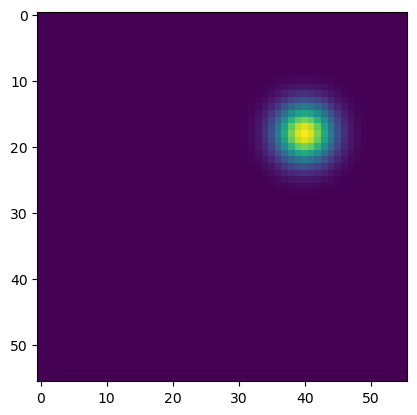

In [7]:
# convert to joint heatmaps from coordiantes: 
heatmaps = generate_gaussian_heatmap(annot_resize[0:10],(56,56),3)
print(heatmaps.shape)
plt.imshow(heatmaps[0][2])
print(heatmaps[0][2].shape)
z = np.unravel_index(heatmaps[0,2,:,:].argmax(), heatmaps[0,2,:,:].shape)
print(z)
print(annot_resize[0,2,:])

In [ ]:
model = TransformerPoseModel(2)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = JointsMSELoss()
model.to(device)

train(
  epochs=250,
  model=model,
  optimizer=optimizer,
  loss_func=loss_func,
  data_loader=data_loader,
  device=device,
  save_name='softmax',
  save_freq=50
  )

# validate(
#   model=model,
#   optimizer=optimizer,
#   loss_func=loss_func,
#   data_loader=data_loader, # TODO: Update this with Original LSP dataloader
#   device=device
# )

In [ ]:
plot_many(model, device, data_loader)

In [ ]:
# code to load a pre-trained model

model = TransformerPoseModel(2)
model.load_state_dict(torch.load('/Users/richardpignatiello/repos/4701/JointPoseEstimation/trained_models/softmax_200.pth'))
model.to(device)